# Visualizing intermediate activations

In [2]:
from keras.models import load_model
from keras import models
from keras.preprocessing import image
from keras.applications import VGG16
from keras import backend as K
from keras.applications.vgg16 import preprocess_input, decode_predictions
import matplotlib.pyplot as plt
import numpy as np
import cv2

Using TensorFlow backend.


In [2]:
model = load_model('./cats_and_dogs_small_2.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

(1, 150, 150, 3)


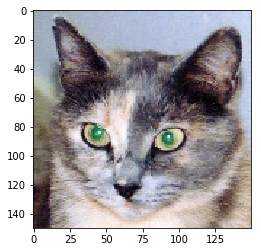

In [3]:
img_path = './datasets/cats_and_dogs_small/test/cats/cat.1700.jpg'
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)
plt.imshow(img_tensor[0])

In [4]:
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

In [5]:
first_layer_activation = activations[0]
first_layer_activation.shape

(1, 148, 148, 32)

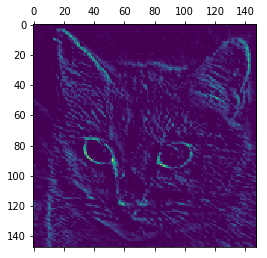

In [6]:
plt.matshow(first_layer_activation[0,:,:,0])

Visualize all the activations.

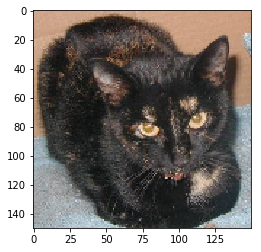

In [7]:
img_path = './datasets/cats_and_dogs_small/test/cats/cat.1720.jpg'
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

/home/ante/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


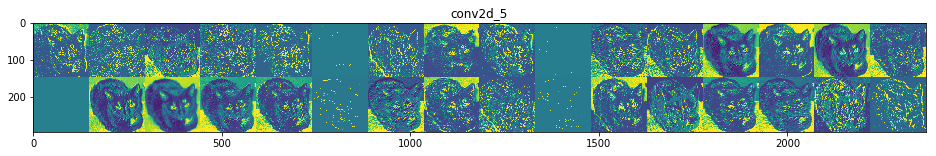

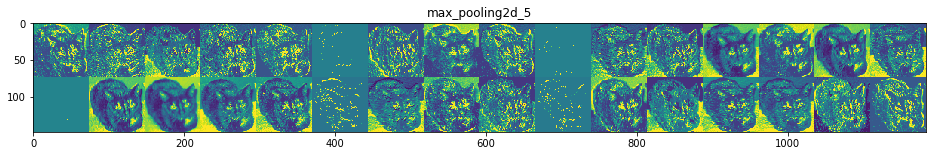

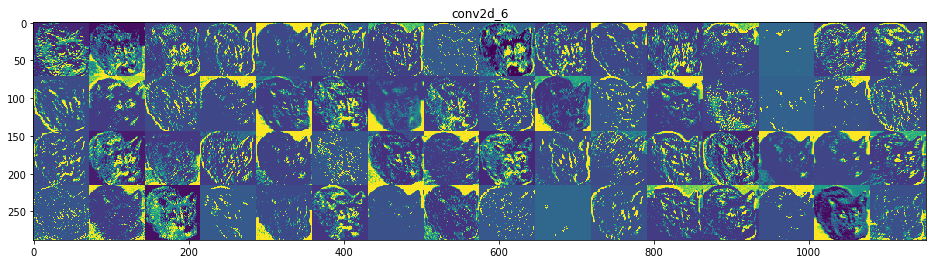

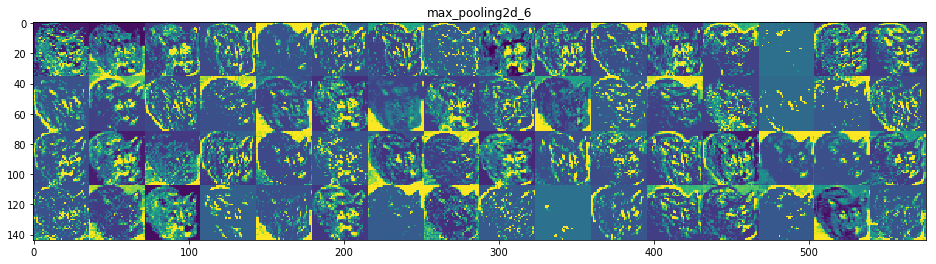

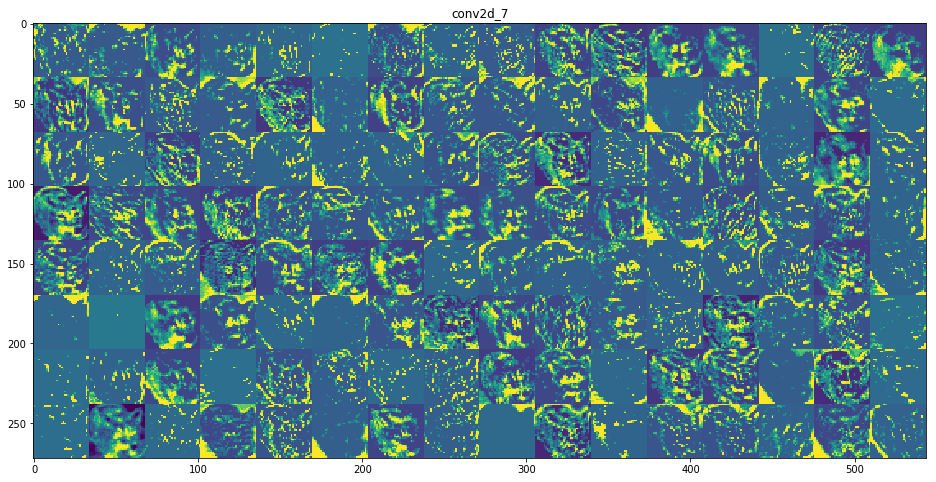

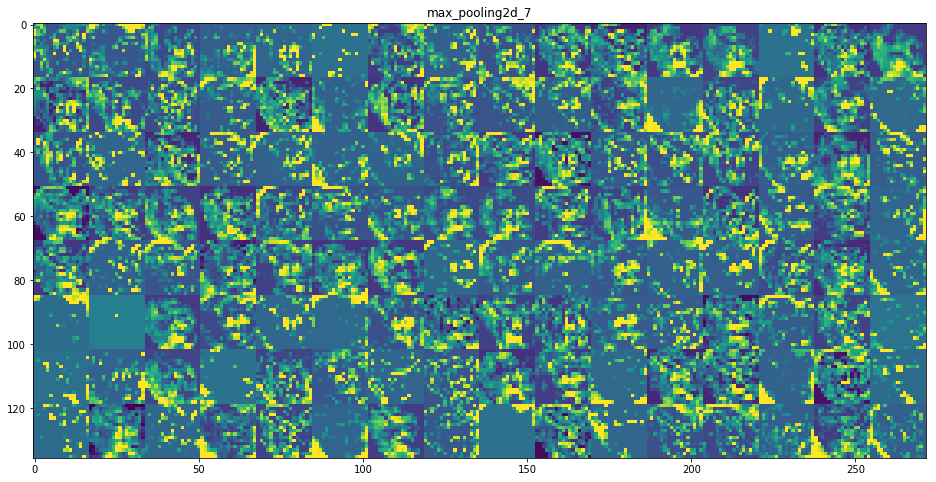

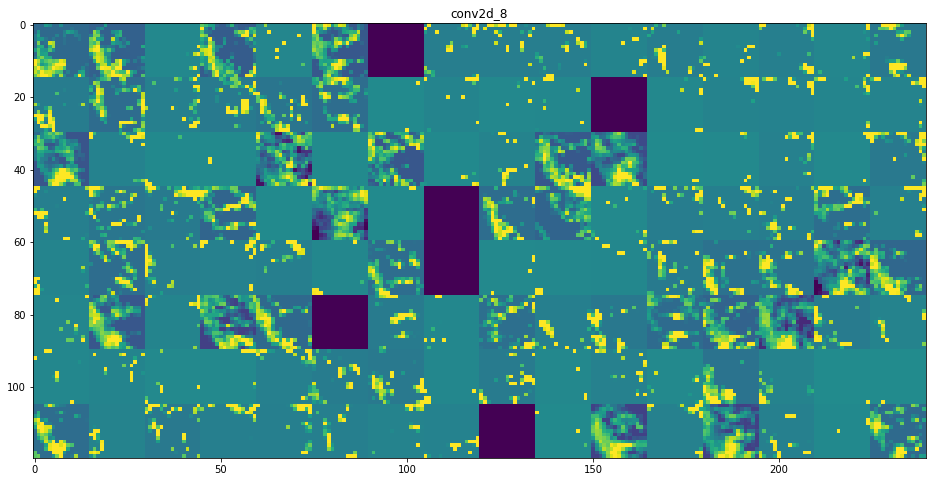

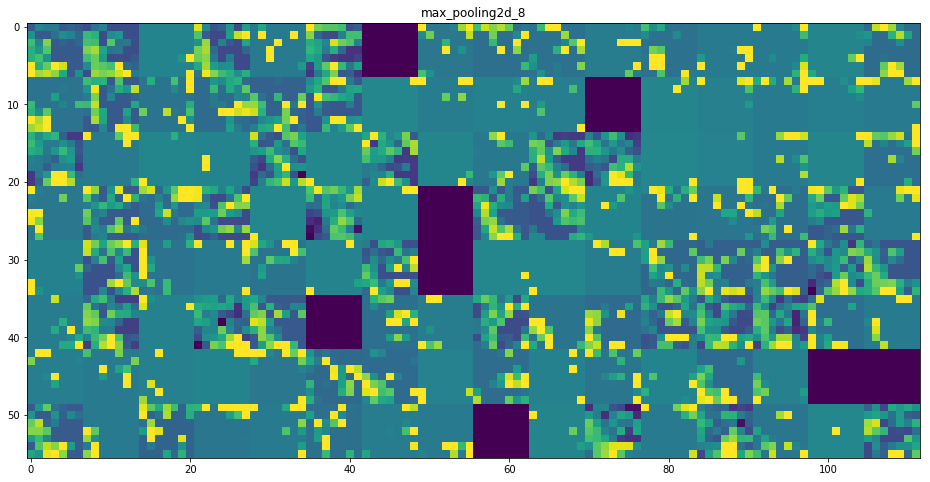

In [8]:
layer_names = [layer.name for layer in model.layers[:8]]
images_per_row = 16
for layer_name, layer_activation in zip(layer_names,activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:,:, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size :(col + 1) * size, row * size :(row + 1) * size] = channel_image
    scale =1./size
    plt.figure(figsize=(scale * display_grid.shape[1],scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto',cmap='viridis')
        

## Visualizing convnet filters

This is done through gradient ascent in input space. That is to say maximizing the reponse of a specific filter over an image through gradient descent.

Loss for an empty image made by VGG16, imageNet, layer block3_conv1, filter 0:
0.000000


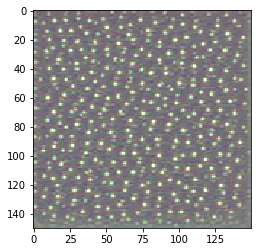

In [9]:
# we use the VGG16 trained on image net.
model = VGG16(weights='imagenet',include_top=False)
layer_name = 'block3_conv1'
filter_index = 0

# Create a loss function based on a single filter mean output.
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

# Get its gradient.
grads = K.gradients(loss, model.input)[0]
# Normalize(L2) it so that gradient descent goes smoothly.
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) # We add 1e-5 to avoid dividing by 0.

# Iterate takes model input and returns loss and gradients.
iterate = K.function([model.input], [loss, grads])
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])
print(f"Loss for an empty image made by VGG16, imageNet, layer {layer_name}, filter {filter_index}:\n{loss_value:6f}")

# Maximize the loss value finding an input the filter maximally responds to.
input_img_data = np.random.random((1,150,150,3)) * 20 + 128 # gray image with noise
step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

# Deprocess image to a displayable one.
def deprocess_image(x):
    # Normalize to 0 mean with std 0.1, move to 0.5 mean and clip to [0,1].
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    # Transform intu uint8 image.
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x
plt.imshow(deprocess_image(input_img_data[0]))

In [10]:
# Turn previous cell into a function.
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) # We add 1e-5 to avoid dividing by 0.
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1,size,size,3)) * 20 + 128 # gray image with noise
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    img=input_img_data[0]
    def deprocess_image(x):
        # Deprocess image to a displayable one.
        # Normalize to 0 mean with std 0.1, move to 0.5 mean and clip to [0,1].
        x -= x.mean()
        x /= (x.std() + 1e-5)
        x *= 0.1
        x += 0.5
        x = np.clip(x, 0, 1)
        # Transform intu uint8 image.
        x *= 255
        x = np.clip(x, 0, 255).astype('uint8')
        return x
    return deprocess_image(img)

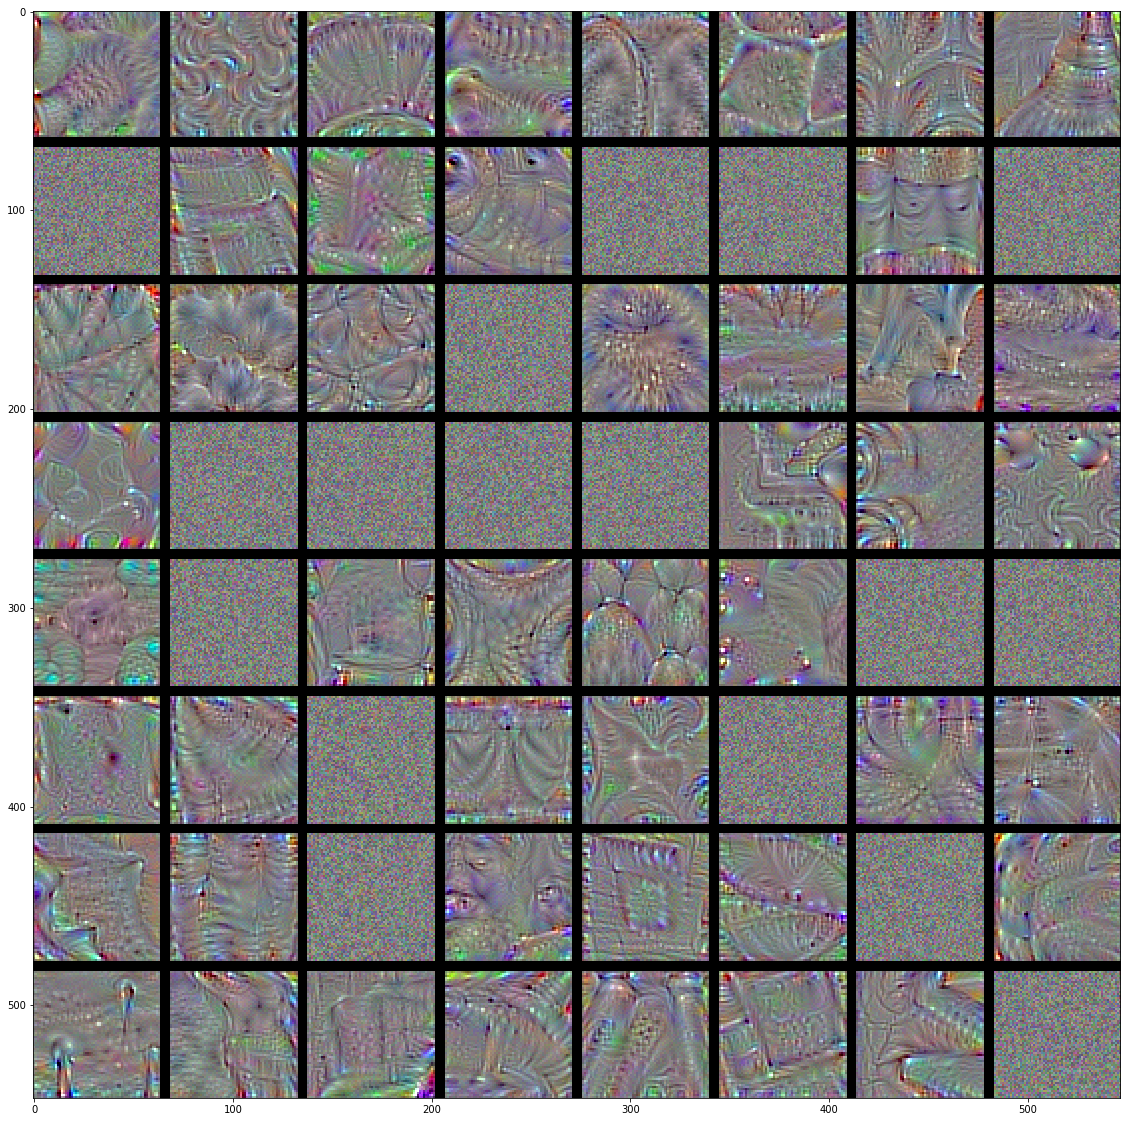

In [21]:
layer_name = 'block1_conv1'
size = 64
margin = 5
results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3),dtype='uint8')
for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8),size=size)
        horizontal_start = i * size + i * margin
        horizontal_end   = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end   = vertical_start + size
        results[horizontal_start:horizontal_end,vertical_start:vertical_end] = filter_img
plt.figure(figsize=(20, 20))
plt.imshow(results)

## Visualize heatmaps of class activation

Predicted: [('n02504458', 'African_elephant', 0.4061678), ('n02504013', 'Indian_elephant', 0.27367193), ('n01871265', 'tusker', 0.26431128)]


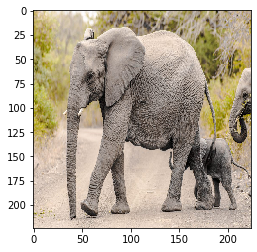

In [35]:
model = VGG16(weights='imagenet')
img_path = 'datasets/elephant2.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x,axis=0)
x = preprocess_input(x)
plt.imshow(img)
preds = model.predict(x)
print(f"Predicted: {decode_predictions(preds,top=3)[0]}")

Setup Grad-CAM process to see which parts of the picture activated the class.

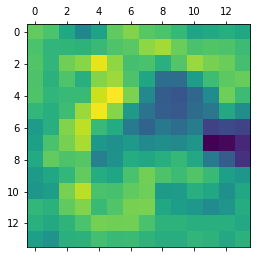

In [53]:
african_elephant_output = model.output[:,386]     # Target output.
last_conv_layer = model.get_layer('block5_conv3')

# Gradients of the elephant output with regards to output feature map.
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
# each entry is the mean intensity of the gradient per channel(512 channels).
pooled_grads = K.mean(grads, axis=(0, 1, 2))
# Access the values. Needs to be doen via function because of the way tf and keras work.
iterate = K.function([model.input],[pooled_grads, last_conv_layer.output[0]])
# Get the values.
pooled_grads_value, conv_layer_output_value = iterate([x])
# Multiply each channel by how important it is for the elephant class.
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
# Final heatmap is a mean of all the channels.
heatmap = np.mean(conv_layer_output_value, axis=-1)

# Normalize the heatmap.
# heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)

plt.matshow(heatmap)

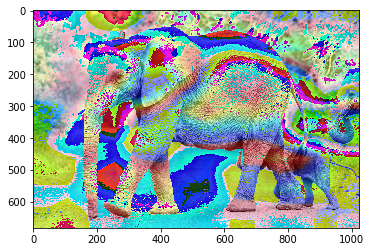

In [54]:
img = cv2.imread(img_path)
heatmap2 = cv2.resize(heatmap, (img.shape[1],img.shape[0]))
heatmap2 = np.uint8(255 * heatmap2)
heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)
superimposed_img = heatmap2 * 0.4 + img
cv2.imwrite('datasets/elephant_cam2.jpeg', superimposed_img)
plt.imshow(superimposed_img.astype('uint8'))

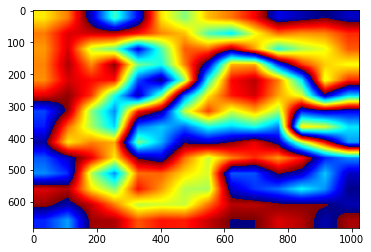

In [55]:
plt.imshow(heatmap2)


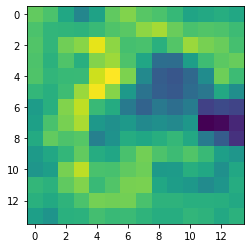

In [56]:
plt.imshow(heatmap)

I am not sure that these results are good I should re check everything